# Mancala Game Implementation

In this assignment, you are tasked with implementing various functions for a Mancala game. The game is played on a board with specific rules, and you will need to implement the core game logic by completing the `play`, `valid_move`, and `winning_eval` functions. You are provided with the `init` and `display_board` functions. The assignment is divided into two parts:

## Mancala rules for this homework assignment
**(there are many different rules sets for Mancala.  Please read this before writing the code)**

* Players sit on opposite sides of the long edge of the board
* There are 6 small pits in the middle of the board and 2 large ones at each end.  The small ones in the middle and the large pit on your right are yours.  The small ones on the other side and the large pit to your opponent's right are theirs
* The large pits at the end of the board are called Mancalas
* Set up the board with 4 stones per small pit (none in the mancalas)
* On every turn, select a pit on your side of the board that contains one or more stones,  then distribute its stones, one stone per pit, in an counter-clockwise direction until you have no stones remaining
* If you encounter your opponent's mandala, skip it
* If you encounter your mancala, drop a stone into it
* If the last stone lands in an empty pit on your side of the board, capture this stone and any stones in your opponent's pit on the other side of the board, collect all of these stones, including the one that just landed, and place them into your mancala.
* If either player's pits are entirely empty, the game concludes. 
* The player who still has stones on his side of the board when the game concludes places all of these pieces into their mancala.
The player with the most stones in their mancala is declared the winner. If both players have an equal number of stones in their mancala, the game results in a tie.


**Please make sure to call the `display_board` function after each move for both the parts and run all the cells before submitting**

In [2]:

import numpy as np
import copy
import time
import matplotlib.pyplot as plt


In [ ]:
class Mancala:
    def __init__(self, pits_per_player=6, stones_per_pit=4):
        """
        The constructor for the Mancala class defines several instance variables:

        pits_per_player: This variable stores the number of pits each player has.
        stones_per_pit: It represents the number of stones each pit contains at the start of any game.
        board: This data structure is responsible for managing the Mancala board.
        current_player: This variable takes the value 1 or 2, as it's a two-player game, indicating which player's turn it is.
        moves: This is a list used to store the moves made by each player. It's structured in the format (current_player, chosen_pit).
        p1_pits_index: A list containing two elements representing the start and end indices of player 1's pits in the board data structure.
        p2_pits_index: Similar to p1_pits_index, it contains the start and end indices for player 2's pits on the board.
        p1_mancala_index and p2_mancala_index: These variables hold the indices of the Mancala pits on the board for players 1 and 2, respectively.
        """
        self.pits_per_player = pits_per_player
        self.board = [stones_per_pit] * ((pits_per_player + 1) * 2)
        self.players = 2
        self.current_player = 1
        self.moves = []
        self.p1_pits_index = [0, self.pits_per_player - 1]
        self.p1_mancala_index = self.pits_per_player
        self.p2_pits_index = [self.pits_per_player + 1, len(self.board) - 2]
        self.p2_mancala_index = len(self.board) - 1
        self.board[self.p1_mancala_index] = 0
        self.board[self.p2_mancala_index] = 0

    def display_board(self):
        """
        Displays the board in a user-friendly format
        """
        player_1_pits = self.board[self.p1_pits_index[0]: self.p1_pits_index[1] + 1]
        player_1_mancala = self.board[self.p1_mancala_index]
        player_2_pits = self.board[self.p2_pits_index[0]: self.p2_pits_index[1] + 1]
        player_2_mancala = self.board[self.p2_mancala_index]
        print('P1               P2')
        print('     ____{}____     '.format(player_2_mancala))
        for i in range(self.pits_per_player):
            if i == self.pits_per_player - 1:
                print('{} -> |_{}_|_{}_| <- {}'.format(i + 1, player_1_pits[i], player_2_pits[-(i + 1)], self.pits_per_player - i))
            else:
                print('{} -> | {} | {} | <- {}'.format(i + 1, player_1_pits[i], player_2_pits[-(i + 1)], self.pits_per_player - i))
        print('         {}         '.format(player_1_mancala))
        turn = 'P1' if self.current_player == 1 else 'P2'
        print('Turn: ' + turn)

    def valid_move(self, pit):
        """
        Function to check if the pit chosen by the current_player is a valid move.
        """
        if not (pit >= 1 and pit <= self.pits_per_player):
            return False
        if self.current_player == 1:
            return self.board[pit - 1] != 0
        else:
            return self.board[pit + self.pits_per_player] != 0

    def random_move_generator(self):
        """
        Function to generate random valid moves with non-empty pits for the random player
        """
        if self.current_player == 1:
            player_1_pits = range(self.p1_pits_index[0], self.p1_pits_index[1] + 1)
            valid_player_1_pits = [i for i in player_1_pits if self.board[i] > 0]
            return np.random.choice(valid_player_1_pits) + 1
        else:
            player_2_pits = range(self.p2_pits_index[0], self.p2_pits_index[1] + 1)
            valid_player_2_pits = [i for i in player_2_pits if self.board[i] > 0]
            return np.random.choice(valid_player_2_pits) - self.pits_per_player

    def play(self, pit):
        """
        Simulates a single move made by a player.
        """
        _, over_or_not = self.winning_eval()
        if over_or_not:
            return
        if not self.valid_move(pit):
            return
        if self.current_player == 1:
            stones_dist = self.board[pit - 1]
            self.board[pit - 1] = 0
            idx = (pit) % len(self.board)
            while stones_dist > 0:
                if idx == self.p2_mancala_index:
                    idx = (idx + 1) % len(self.board)
                    continue
                if idx >= self.p1_pits_index[0] and idx <= self.p1_pits_index[1] and self.board[idx] == 0 and stones_dist == 1:
                    opposite_pit = self.p2_pits_index[1] - (idx - self.p1_pits_index[0])
                    stones_taken = self.board[opposite_pit]
                    self.board[opposite_pit] = 0
                    self.board[self.p1_mancala_index] += stones_taken + 1
                    break
                self.board[idx] += 1
                stones_dist -= 1
                idx = (idx + 1) % len(self.board)
            self.moves.append((self.current_player, pit))
            self.current_player = 2
        else:
            stones_dist = self.board[pit + self.pits_per_player]
            self.board[pit + self.pits_per_player] = 0
            idx = (pit + self.pits_per_player + 1) % len(self.board)
            while stones_dist > 0:
                if idx == self.p1_mancala_index:
                    idx = (idx + 1) % len(self.board)
                    continue
                if idx >= self.p2_pits_index[0] and idx <= self.p2_pits_index[1] and self.board[idx] == 0 and stones_dist == 1:
                    opposite_pit = self.p1_pits_index[1] - (idx - self.p2_pits_index[0])
                    stones_taken = self.board[opposite_pit]
                    self.board[opposite_pit] = 0
                    self.board[self.p2_mancala_index] += stones_taken + 1
                    break
                self.board[idx] += 1
                stones_dist -= 1
                idx = (idx + 1) % len(self.board)
            self.moves.append((self.current_player, pit))
            self.current_player = 1
        return self.board

    def winning_eval(self):
        """
        Function to verify if the game board has reached the winning state.
        """
        player_1_endgame = True
        for i in range(self.p1_pits_index[0], self.p1_pits_index[1] + 1):
            if self.board[i] != 0:
                player_1_endgame = False
                break
        player_2_endgame = True
        for i in range(self.p2_pits_index[0], self.p2_pits_index[1] + 1):
            if self.board[i] != 0:
                player_2_endgame = False
                break
        if player_1_endgame or player_2_endgame:
            winner = None
            remaining_player_1_stones = sum(self.board[i] for i in range(self.p1_pits_index[0], self.p1_pits_index[1] + 1))
            remaining_player_2_stones = sum(self.board[i] for i in range(self.p2_pits_index[0], self.p2_pits_index[1] + 1))
            for i in range(self.p1_pits_index[0], self.p1_pits_index[1] + 1):
                self.board[i] = 0
            for i in range(self.p2_pits_index[0], self.p2_pits_index[1] + 1):
                self.board[i] = 0
            self.board[self.p1_mancala_index] += remaining_player_1_stones
            self.board[self.p2_mancala_index] += remaining_player_2_stones
            if self.board[self.p1_mancala_index] > self.board[self.p2_mancala_index]:
                winner = "Player 1"
            elif self.board[self.p1_mancala_index] < self.board[self.p2_mancala_index]:
                winner = "Player 2"
            else:
                winner = "Tie"
            return winner, True
        return "GAME NOT OVER", False

    def next_possible_states(self, board, player):
        successors = []
        if player == 1:
            pit_start, pit_end = self.p1_pits_index
            mancala_index = self.p1_mancala_index
            opp_mancala = self.p2_mancala_index
        else:
            pit_start, pit_end = self.p2_pits_index
            mancala_index = self.p2_mancala_index
            opp_mancala = self.p1_mancala_index
        for offset, pit_index in enumerate(range(pit_start, pit_end + 1), start=1):
            stones = board[pit_index]
            if stones == 0:
                continue
            new_board = copy.deepcopy(board)
            hand = new_board[pit_index]
            new_board[pit_index] = 0
            idx = (pit_index + 1) % len(new_board)
            while hand > 0:
                if idx == opp_mancala:
                    idx = (idx + 1) % len(new_board)
                    continue
                if hand == 1:
                    is_own_side = (pit_start <= idx <= pit_end)
                    if is_own_side and new_board[idx] == 0:
                        if player == 1:
                            opposite_index = self.p2_pits_index[1] - (idx - self.p1_pits_index[0])
                        else:
                            opposite_index = self.p1_pits_index[1] - (idx - self.p2_pits_index[0])
                        captured = new_board[opposite_index]
                        new_board[opposite_index] = 0
                        new_board[mancala_index] += 1 + captured
                        hand = 0
                        break
                new_board[idx] += 1
                hand -= 1
                idx = (idx + 1) % len(new_board)
            next_player = 2 if player == 1 else 1

            successors.append((offset, new_board, next_player))
        return successors

    def is_terminal(self, board):
        p1_empty = all(board[i] == 0 for i in range(self.p1_pits_index[0], self.p1_pits_index[1] + 1))
        p2_empty = all(board[i] == 0 for i in range(self.p2_pits_index[0], self.p2_pits_index[1] + 1))
        return p1_empty or p2_empty

    def final_sweep(self, board):
        new_board = copy.deepcopy(board)
        p1_empty = all(new_board[i] == 0 for i in range(self.p1_pits_index[0], self.p1_pits_index[1] + 1))
        p2_empty = all(new_board[i] == 0 for i in range(self.p2_pits_index[0], self.p2_pits_index[1] + 1))
        if p1_empty and not p2_empty:
            p2_remaining = sum(new_board[i] for i in range(self.p2_pits_index[0], self.p2_pits_index[1] + 1))
            for i in range(self.p2_pits_index[0], self.p2_pits_index[1] + 1):
                new_board[i] = 0
            new_board[self.p2_mancala_index] += p2_remaining
        if p2_empty and not p1_empty:
            p1_remaining = sum(new_board[i] for i in range(self.p1_pits_index[0], self.p1_pits_index[1] + 1))
            for i in range(self.p1_pits_index[0], self.p1_pits_index[1] + 1):
                new_board[i] = 0
            new_board[self.p1_mancala_index] += p1_remaining
        return new_board
    # def utility(self, board, max_player): 
    #     p1_score = board[self.p1_mancala_index]  
    #     p2_score = board[self.p2_mancala_index] 
    #     if max_player == 1: 
    #         return p1_score - p2_score 
    #     else:
    #         return p2_score - p1_score
    def utility(self, board, max_player):
        p1_m = board[self.p1_mancala_index]
        p2_m = board[self.p2_mancala_index]
        p1_pits = board[self.p1_pits_index[0]: self.p1_pits_index[1] + 1]
        p2_pits = board[self.p2_pits_index[0]: self.p2_pits_index[1] + 1]
        score_diff = p1_m - p2_m
        pit_stone_diff = sum(p1_pits) - sum(p2_pits)
        p1_capture_potential = sum(1 for s in p1_pits if s == 1)
        p2_capture_potential = sum(1 for s in p2_pits if s == 1)

        capture_diff = p1_capture_potential - p2_capture_potential
        value = (4 * score_diff + 1 * pit_stone_diff + 2 * capture_diff)
        return value if max_player == 1 else -value

    def minimax(self, board, depth, player, max_player):
        if depth == 0 or self.is_terminal(board):
            if self.is_terminal(board):
                board = self.final_sweep(board)
            return self.utility(board, max_player), None
        successors = self.next_possible_states(board, player)
        if len(successors) == 0:
            return self.utility(board, max_player), None
        if player == max_player:
            best_value = -float('inf')
            best_move = None
            for move, child_board, next_player in successors:
                value, _ = self.minimax(child_board, depth - 1, next_player, max_player)
                if value > best_value:
                    best_value = value
                    best_move = move
            return best_value, best_move
        else:
            best_value = float('inf')
            best_move = None
            for move, child_board, next_player in successors:
                value, _ = self.minimax(child_board, depth - 1, next_player, max_player)
                if value < best_value:
                    best_value = value
                    best_move = move
            return best_value, best_move

    def ai_move_minimax(self, depth):
        _, best_move = self.minimax(self.board, depth, self.current_player, self.current_player)
        return best_move

    def play_minimax_vs_random_game(self, depth):
        game = Mancala(self.pits_per_player, 4)
        moves = 0
        while True:
            winner, over = game.winning_eval()
            if over:
                return winner, moves
            if game.current_player == 1:
                move = game.ai_move_minimax(depth)
                game.play(move)
            else:
                move = game.random_move_generator()
                game.play(move)
            moves += 1

    def run_minimax_vs_random_experiment(self, depth=5, n_games=100):
        results = {"Player 1": 0, "Player 2": 0, "Tie": 0}
        move_counts = []
        for _ in range(n_games):
            winner, moves = self.play_minimax_vs_random_game(depth)
            results[winner] += 1
            move_counts.append(moves)
        percentages = {
            "Player 1 %": results["Player 1"] / n_games * 100,
            "Player 2 %": results["Player 2"] / n_games * 100,
            "Tie %":      results["Tie"] / n_games * 100
        }
        avg_moves = sum(move_counts) / n_games
        return percentages, avg_moves

    def alpha_beta(self, board, depth, player, max_player, alpha, beta):
        if depth == 0 or self.is_terminal(board):
            if self.is_terminal(board):
                board = self.final_sweep(board)
            return self.utility(board, max_player), None
        successors = self.next_possible_states(board, player)

        if len(successors) == 0:
            return self.utility(board, max_player), None
        if player == max_player:
            best_value = -float('inf')
            best_move = None
            for move, child_board, next_player in successors:
                value, _ = self.alpha_beta(
                    child_board, depth - 1, next_player, max_player, alpha, beta
                )
                if value > best_value:
                    best_value = value
                    best_move = move
                alpha = max(alpha, best_value)
                if alpha >= beta:
                    break
            return best_value, best_move
        else:
            best_value = float('inf')
            best_move = None
            for move, child_board, next_player in successors:
                value, _ = self.alpha_beta(
                    child_board, depth - 1, next_player, max_player, alpha, beta
                )
                if value < best_value:
                    best_value = value
                    best_move = move
                beta = min(beta, best_value)
                if alpha >= beta:
                    break
            return best_value, best_move

    def ai_move_alpha_beta(self, depth):
        _, best_move = self.alpha_beta(
            self.board, depth, self.current_player, self.current_player,
            alpha=-float('inf'), beta=float('inf')
        )
        return best_move

    def play_ai_vs_random_ab(self, depth):
        game = Mancala(self.pits_per_player, 4)
        move_count = 0
        start = time.time()
        while True:
            winner, over = game.winning_eval()
            if over:
                end = time.time()
                return winner, move_count, (end - start)
            if game.current_player == 1:
                move = game.ai_move_alpha_beta(depth)
                game.play(move)
            else:
                move = game.random_move_generator()
                game.play(move)
            move_count += 1

    def run_ab_vs_random_experiment(self, depth=10, n_games=100):
        results = {"Player 1": 0, "Player 2": 0, "Tie": 0}
        move_list = []

        time_list = []
        for _ in range(n_games):
            winner, moves, runtime = self.play_ai_vs_random_ab(depth)
            results[winner] += 1
            move_list.append(moves)
            time_list.append(runtime)
        percent = {
            "Player 1 %": results["Player 1"] / n_games * 100,
            "Player 2 %": results["Player 2"] / n_games * 100,
            "Tie %":      results["Tie"] / n_games * 100
        }
        avg_moves = sum(move_list) / n_games
        avg_time  = sum(time_list) / n_games
        return percent, avg_moves, avg_time

    def time_minimax(self, depth):
        start = time.time()
        self.minimax(self.board, depth, self.current_player, self.current_player)
        return time.time() - start

    def time_ab(self, depth):
        start = time.time()
        self.alpha_beta(self.board, depth, self.current_player, self.current_player,
                        -float("inf"), float("inf"))
        return time.time() - start

    def project_minimax_runtime(self, depth_small, depth_large):
        t_small = self.time_minimax(depth_small)
        branching_factor = 6
        factor = branching_factor ** (depth_large - depth_small)
        return t_small * factor

    def plot_win_curve(self, depths=[2,5,10], n_games=50):
        win_rates = []
        for d in depths:
            percent, _, _ = self.run_ab_vs_random_experiment(depth=d, n_games=n_games)
            win_rates.append(percent["Player 1 %"])
        plt.plot(depths, win_rates, marker='o')
        plt.xlabel("Search Depth (plies)")
        plt.ylabel("AI Win %")
        plt.title("Alpha-Beta Win Rate vs Search Depth")
        plt.grid(True)
        plt.show()



Now, we implement the random player part of the project.

In [4]:
def play_a_game():
    game = Mancala()
    winner, game_condition = game.winning_eval()
    counter = 1
    while not game_condition:
        # current player makes a move
        random_play = game.random_move_generator()

        game.play(random_play)

        
        winner, game_condition = game.winning_eval()
        counter += 1
    moves = {
        'Player 1' : 0,
        'Player 2' : 0
    }
    for i,_ in game.moves:
        if i == 1:
            moves['Player 1'] += 1
        else:
            moves['Player 2'] += 1

    return winner, moves



Play 100 games of random player against random player  
- What percentage of games does each player (1st or 2nd) win?  
- On average, how many moves does it take to win?  
- You should see a small first player advantage in your random against random games  
- We expect the first player to win about 50–55% of the time over 100 games. Since this process is random, the percentage of wins can vary  

Result for 100 stimulation.

In [5]:
from collections import Counter
c = Counter()
size = 100
total_moves = {
    'Player 1' : 0,
    'Player 2' : 0
}
for _ in range(0,size):
    winner, moves = play_a_game()
    total_moves['Player 1'] += moves['Player 1']
    total_moves['Player 2'] += moves['Player 2']
    c[winner] += 1

print(c)
print(f"player 1 = {c['Player 1']/size}, player 2 = {c['Player 2']/size}, Tie = {c['Tie']/size}")
print(f"Average move per game for Player 1: {total_moves['Player 1']/size}, Average move per game for player 2: {total_moves['Player 2']/size}")

Counter({'Player 1': 55, 'Player 2': 37, 'Tie': 8})
player 1 = 0.55, player 2 = 0.37, Tie = 0.08
Average move per game for Player 1: 21.54, Average move per game for player 2: 21.14


Results for 500,000 stimulation.

In [6]:
from collections import Counter
c = Counter()
size = 500000
total_moves = {
    'Player 1' : 0,
    'Player 2' : 0
}
for _ in range(0,size):
    winner, moves = play_a_game()
    total_moves['Player 1'] += moves['Player 1']
    total_moves['Player 2'] += moves['Player 2']
    c[winner] += 1

print(c)
print(f"player 1 = {c['Player 1']/size}, player 2 = {c['Player 2']/size}, Tie = {c['Tie']/size}")
print(f"Average move per game for Player 1: {total_moves['Player 1']/size}, Average move per game for player 2: {total_moves['Player 2']/size}")

Counter({'Player 1': 240327, 'Player 2': 226130, 'Tie': 33543})
player 1 = 0.480654, player 2 = 0.45226, Tie = 0.067086
Average move per game for Player 1: 20.713968, Average move per game for player 2: 20.212594


Play 100 games with the random player against the minimax AI player at a depth of 5 plies
- What percentage of games does each player (AI or random) win?
- On average, how many moves does it take to win?
- Is your AI player better than random chance? Write a paragraph or two describing or why not

In [36]:
m = Mancala()
percent, avg_moves = m.run_minimax_vs_random_experiment(depth=5, n_games=100)

print("Win Percentages:", percent)
print("Average Moves:", avg_moves)

Win Percentages: {'Player 1 %': 97.0, 'Player 2 %': 3.0, 'Tie %': 0.0}
Average Moves: 26.02


Play 100 games with the random player against the Alpha-Beta AI player at a depth of 5 plies
- How long does it take for a single game to run to completion?
- What percentage of games does each player (AI or random) win?
- On average, how many moves does it take to win?
- Are your results for this part different from those for your minimax AI player?
- Write a paragraph or two describing why or why not

In [22]:
m = Mancala()
percent, avg_moves, avg_time = m.run_ab_vs_random_experiment(depth=5, n_games=100)

print("Win Percentages:", percent)
print("Average Moves:", avg_moves)
print("Average Time per Game:", avg_time)


Win Percentages: {'Player 1 %': 97.0, 'Player 2 %': 1.0, 'Tie %': 2.0}
Average Moves: 27.47
Average Time per Game: 0.03835455417633057


Play 100 games with the random player against the Alpha-Beta AI player at a depth of 10 plies
- How long does it take for a single game to run to completion?
- What percentage of games does each player (AI or random) win?
- On average, how many moves does it take to win?
- How much does the Alpha Beta algorithm speed up the game. Compare your run time for 5 ply minimax against 5 ply Alpha Beta. Project how long Minimax would take to run 10 plies.
- Plot a curve showing the win percentage for a player looking ahead 2 plies, 5 plies and 10 plies
- As you increase the number of plies, does the AI player win more games? Explain why or why not

In [21]:
m = Mancala()

percent, avg_moves, avg_time = m.run_ab_vs_random_experiment(depth=10, n_games=100)

print("Win Percentages:", percent)
print("Average Moves:", avg_moves)
print("Average Time per Game:", avg_time)


Win Percentages: {'Player 1 %': 99.0, 'Player 2 %': 1.0, 'Tie %': 0.0}
Average Moves: 25.36
Average Time per Game: 4.78242152929306


In [23]:
m = Mancala()
t_minimax = m.time_minimax(depth=5)
print("Minimax 5-ply time:", t_minimax)


Minimax 5-ply time: 0.034097909927368164


In [24]:
m = Mancala()
t_ab = m.time_ab(depth=5)
print("Alpha-Beta 5-ply time:", t_ab)

Alpha-Beta 5-ply time: 0.012789011001586914


In [25]:
projection = m.project_minimax_runtime(depth_small=5, depth_large=10)
print("Projected Minimax 10-ply runtime:", projection)

Projected Minimax 10-ply runtime: 221.08639526367188


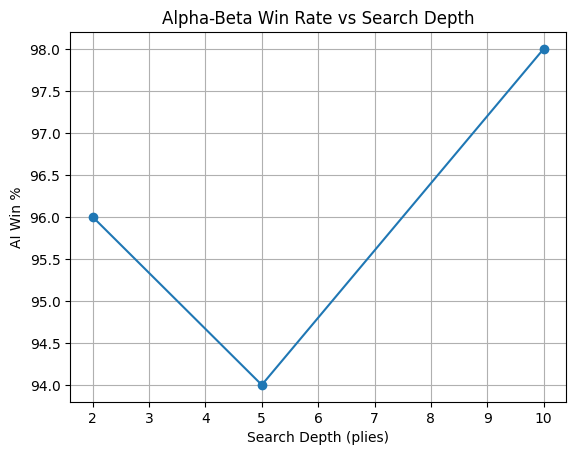

In [26]:
m.plot_win_curve(depths=[2,5,10], n_games=50)

(Extra Credit, 15 points). Change the utility function and play 100 games with the random player against the Alpha-Beta AI player at a depth of 10 plies or more
- How long does it take for a single game to run to completion?
- What percentage of games does each player (AI or random) win?
- On average, how many moves does it take to win?
- In your writeup, explain how your new utility function improves on the utility function described above?
- Explain how increasing the number of plies improve the play for the AI player?
- Is this new utility function a better way to evaluate the strength of a


In [34]:
percent, avg_moves, avg_time = m.run_ab_vs_random_experiment(depth=10, n_games=100)
percent, avg_moves, avg_time


({'Player 1 %': 100.0, 'Player 2 %': 0.0, 'Tie %': 0.0},
 23.87,
 5.069192440509796)

**Note**: For parts except the last one (extra credit), I used the commented basic given utility function.